# SC2008 Lab 4: Analysing Network Data Log

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
TYPE = 0
SFLOW_AGENT_ADDRESS = 1
INPUT_PORT = 2
OUTPUT_PORT = 3
SRC_MAC = 4
DST_MAC = 5
ETHERNET_TYPE = 6
IN_VLAN = 7
OUT_VLAN = 8
SRC_IP = 9
DST_IP = 10
IP_PROTOCOL = 11 
IP_TOS = 12
IP_TTL = 13
SRC_PORT = 14
DST_PORT = 15
TCP_FLAGS = 16
PACKET_SIZE = 17
IP_PACKET_SIZE = 18
SAMPLING_RATE = 19

In [20]:
# Read csv file
sflow_data = pd.read_csv('./SFlow_Data_lab4.csv', header=None)
sflow_data = sflow_data[sflow_data[TYPE] == "FLOW"]
sflow_data.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,FLOW,aa.aa.aa.aa,137,200,d404ff55fd4d,80711fc76001,0x0800,919.0,280,130.246.176.22,...,6,0x00,50,51216.0,23505,0x10,1518,1500,2048,NaN
1,FLOW,aa.aa.aa.aa,129,193,609c9f851b00,0031466b23cf,0x0800,11.0,919,155.69.160.32,...,6,0x00,56,23159.0,80,0x10,74,52,2048,NaN
2,FLOW,aa.aa.aa.aa,137,200,d404ff55fd4d,80711fc76001,0x0800,919.0,280,130.246.176.53,...,6,0x00,50,50041.0,20739,0x10,1518,1500,2048,NaN
3,FLOW,aa.aa.aa.aa,129,135,609c9f851b00,002688cd5fc7,0x0800,11.0,919,155.69.160.32,...,17,0x00,120,54241.0,26510,0x10,116,94,2048,NaN
4,FLOW,aa.aa.aa.aa,130,199,00239cd087c1,544b8cf9a7df,0x0800,919.0,600,137.132.228.15,...,6,0x00,56,53923.0,34262,0x10,70,52,2048,NaN


## Exercise 4A: Top Talkers and Listeners

In [21]:
# Top 5 Talkers
top_5_talkers = sflow_data[SRC_IP].value_counts()
top_5_talkers = list(zip(top_5_talkers.index, top_5_talkers.values))
print("Top 5 Talkers:")
print(f"{'IP':<20}No. of Packets")
for x, y in top_5_talkers[:5]:
    print(f"{x:<20}{y}")

Top 5 Talkers:
IP                  No. of Packets
193.62.192.8        3041
155.69.160.32       2975
130.14.250.11       2604
14.139.196.58       2452
140.112.8.139       2056


In [22]:
# Top 5 Listeners
top_5_listeners = sflow_data[DST_IP].value_counts()
top_5_listeners = list(zip(top_5_listeners.index, top_5_listeners.values))
print("Top 5 Listeners:")
print(f"{'IP':<20}No. of Packets")
for x, y in top_5_listeners[:5]:
    print(f"{x:<20}{y}")


Top 5 Listeners:
IP                  No. of Packets
103.37.198.100      3841
137.132.228.15      3715
202.21.159.244      2446
192.101.107.153     2368
103.21.126.2        2056


## Exercise 4B: Transport Protocol

In [48]:
# TCP vs UDP vs the other protocols
protocols_and_packets = sflow_data[IP_PROTOCOL].value_counts()
packets = protocols_and_packets.sum()

print(f"Total packets: {packets}")
print("Protocol    Number of Packets")
for x, y in protocols_and_packets.items():
    print(f"{x:<12d}{y:<8d} {y / packets * 100:>6.2f}%")

Total packets: 68065
Protocol    Number of Packets
6           56064     82.37%
17          9462      13.90%
50          1698       2.49%
47          657        0.97%
41          104        0.15%
1           74         0.11%
58          4          0.01%
103         1          0.00%
0           1          0.00%


## Exercise 4C: Applications Protocol

In [23]:
# Top 5 destination ip port number
top_5_dst_ip_port_no = sflow_data[DST_PORT].value_counts()[:5]
top_5_dst_ip_port_no = list(
    zip(top_5_dst_ip_port_no.index, top_5_dst_ip_port_no.values)
)
print("Top 5 Destination Port Number:")
print(f"{'Dest. Port Number':<20}No. of Packets")
for x, y in top_5_dst_ip_port_no:
    print(f"{x:<20}{y}")

Top 5 Destination Port Number:
Dest. Port Number   No. of Packets
443                 13423
80                  2647
52866               2068
45512               1356
56152               1341


## Exercise 4D: Traffic

In [24]:
# Total packet size / total traffic
total_packet_size = sflow_data[IP_PACKET_SIZE].sum()
print(f"Total Packet Size (B)   : {total_packet_size}")
print(f"Total Packet Size (MB)  : {total_packet_size / 1024 / 1024}")

Total Packet Size (B)   : 64777822
Total Packet Size (MB)  : 61.77694511413574


## Exercise 4E: Additional Analysis

In [26]:
# Top 5 Communication Pairs
top_5_comm_pairs = sflow_data.groupby([SRC_IP, DST_IP]).size().sort_values(ascending=False)[:5]
print(f"{'Source':<18}{'Destination':<18}Number of Communication Pairs")
for (a, b), y in top_5_comm_pairs.items():
    print(f"{a:<18}{b:<18}{y}")

Source            Destination       Number of Communication Pairs
193.62.192.8      137.132.228.15    3041
130.14.250.11     103.37.198.100    2599
14.139.196.58     192.101.107.153   2368
140.112.8.139     103.21.126.2      2056
137.132.228.15    193.62.192.8      1910


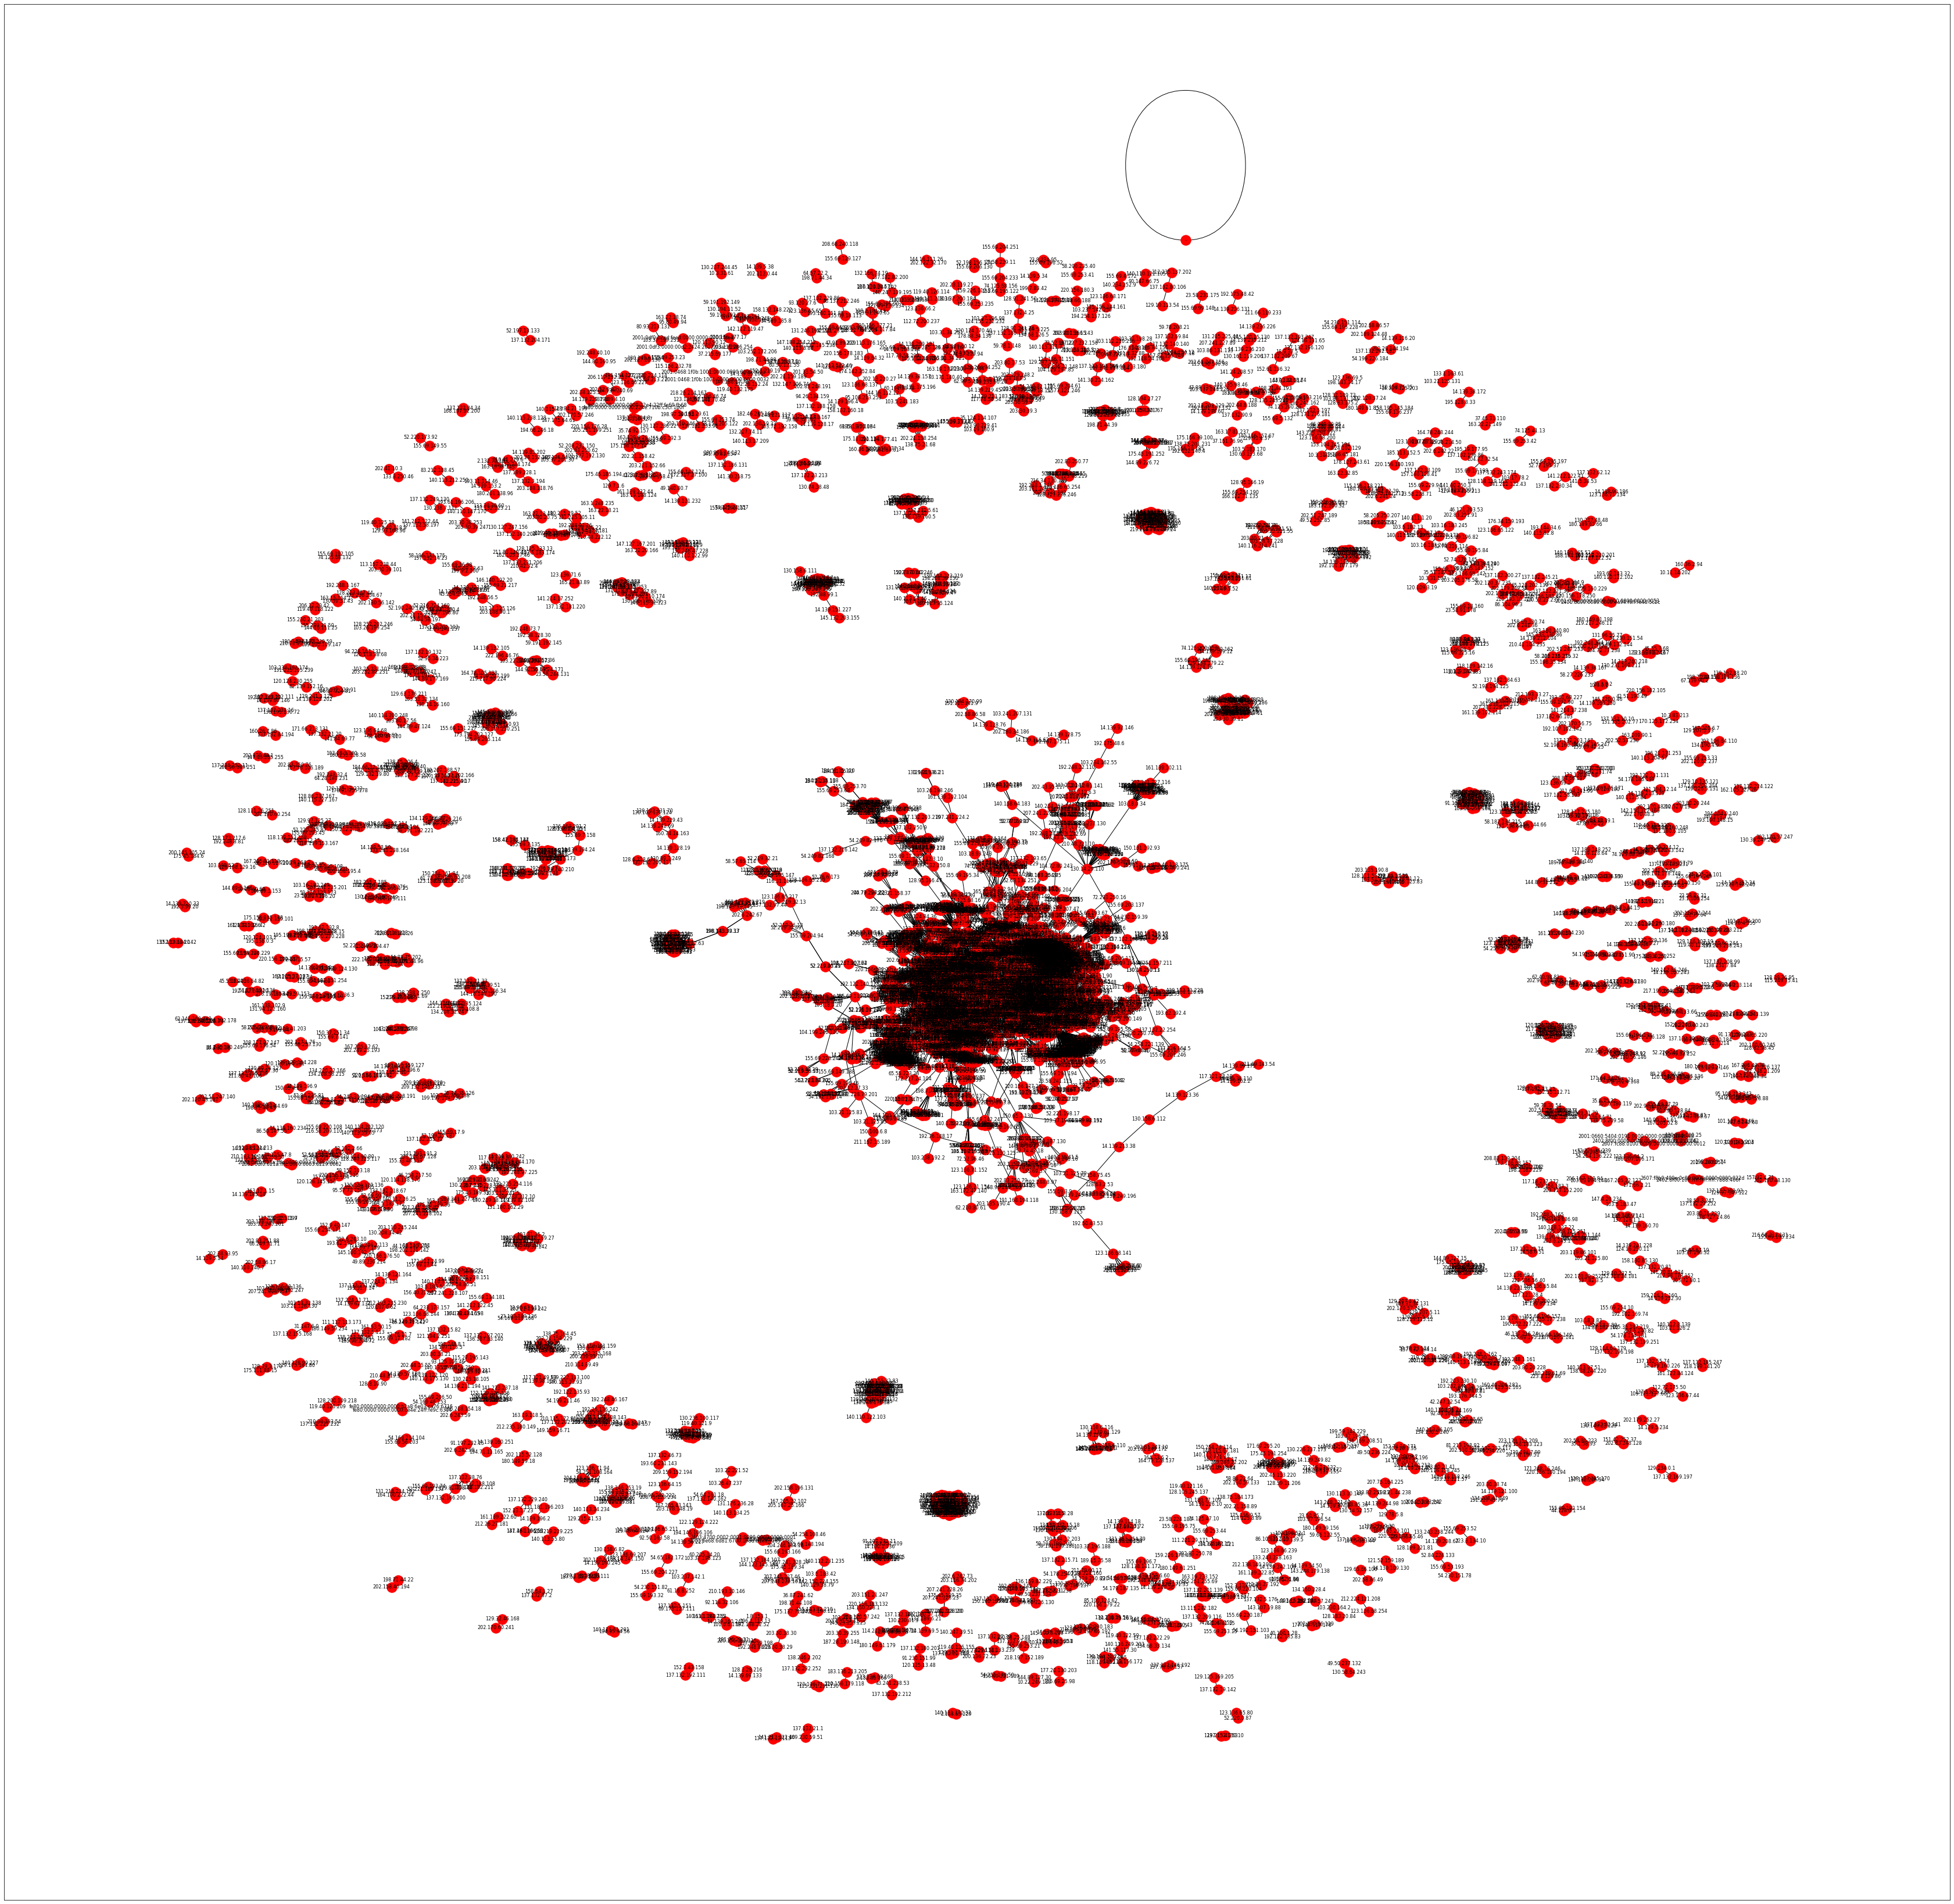

In [29]:
comm_dataset = sflow_data.groupby([SRC_IP, DST_IP]).size().sort_values(ascending=False)

comm_dataframe = pd.DataFrame()
froms = []
tos = []
for (a, b), y in comm_dataset.items():
    froms.append(a)
    tos.append(b)

comm_dataframe["from"] = froms
comm_dataframe["to"] = tos

G = nx.from_pandas_edgelist(comm_dataframe, "from", "to")

plt.figure(figsize=(60, 60))
gp = nx.spring_layout(G)
nx.draw_networkx_nodes(G, gp, node_color="red")
nx.draw_networkx_edges(G, gp)
nx.draw_networkx_labels(G, gp, font_size=8)

plt.show()
